<a href="https://colab.research.google.com/github/AlexTako/AI_practice/blob/main/time%20series%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Решеные задачи:**
1. Выбрал модель.
2. Использовал [датасет](https://storage.yandexcloud.net/academy.ai/AAPL.csv) котировок Apple, обучил модель. Вывел графики: график процесса обучения, сопоставления базового и прогнозного рядов, а также график автокорреляции.


In [ ]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Построение моделей нейронных сетей
from keras.models import Sequential, Model

# Слои
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization
from keras.layers import Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D
from keras.layers import MaxPooling1D, RepeatVector

# Оптимизаторы
from keras.optimizers import Adam

# Генератор выборки временных рядов
from keras.preprocessing.sequence import TimeseriesGenerator

# Нормировка
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Отрисовка графиков
import matplotlib.pyplot as plt
%matplotlib inline

# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

# Отключение лишних предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# импортируем файл с данными о котировках акций Apple
!wget https://storage.yandexcloud.net/academy.ai/AAPL.csv

# Загрузим только необходимые колонки usecols, укажем, что колонку Date необходимо преобразовать в формат DateTime (parse_dates) и сделать индексом index_col
price = pd.read_csv("./AAPL.csv", index_col='Date', usecols = ['Adj Close', 'Volume', 'Date'], parse_dates=['Date'])
price.head()

--2024-04-07 15:41:12--  https://storage.yandexcloud.net/academy.ai/AAPL.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186539 (182K) [text/csv]
Saving to: ‘AAPL.csv.1’

AAPL.csv.1          100%[===================>] 182.17K   402KB/s    in 0.5s    

2024-04-07 15:41:13 (402 KB/s) - ‘AAPL.csv.1’ saved [186539/186539]



,Adj Close,Volume
Date,,
2014-01-02,17.296652,234684800
2014-01-03,16.916719,392467600
2014-01-06,17.008968,412610800
2014-01-07,16.887323,317209200
2014-01-08,16.994270,258529600


In [ ]:
# Функция вычисления коэффициента автокорреляции

def get_corr_coef(
    data, # данные
    lag   # временной лаг
    ):

    array_data = np.asarray(data) # Преобразуем в массив NumPy

    # вычисление матрицы коэффициентов и отбор коэффициента из нужного места матрицы
    return np.corrcoef(array_data[lag:], array_data[:-lag])[0, 1]
np.round(get_corr_coef(np.diff(price['Adj Close']), 5), 2)

# Подготовка генератора
price.drop(columns=['Volume'], inplace=True)
train_data = price[:'2023-01-10']
test_data = price['2023-01-20':]
# Нормировка
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)



In [ ]:
# Проверка формы данных
print(f'Тренировочные данные: {scaled_train_data.shape}')
print(f'Тестовые данные: {scaled_test_data.shape}')

Тренировочные данные: (2272, 1)
Тестовые данные: (299, 1)


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator


n_input = 7  # Размерность входных данных
n_features = 1 # Размерность выходных данных
BATCH_SIZE = 2 # Размер пакета

generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=BATCH_SIZE)
print(f'Форма обучающего пакета: {generator[0][0].shape}, y: {generator[0][1].shape}')

Форма обучающего пакета: (2, 7, 1), y: (2, 1)


In [ ]:
# Валидационная выборка
validator = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=BATCH_SIZE)
print(f'Форма валидационного пакета: {validator[0][0].shape}, y: {validator[0][1].shape}')

Форма валидационного пакета: (2, 7, 1), y: (2, 1)


In [ ]:
# Тестовая выборка
tester = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=scaled_test_data.shape[0])
x_test, y_test = tester[0]
print(f'Форма тестовой выборки: {x_test.shape}, y: {y_test.shape}')

Форма тестовой выборки: (292, 7, 1), y: (292, 1)


In [ ]:
# Вспомогательные функции
# Объявление функции графика обучения
def history_plot(history, title):

    # Рисование графиков обучения
    fig = plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    plt.title(f'{title}. График обучения')

    # Показываем только целые метки шкалы оси x
    fig.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

# Функция расчета корреляции для двух рядов
def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, title=''):

    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    plt.plot(y_pred[1:], label=f'Прогноз')
    plt.plot(y_true[:-1], label=f'Базовый')
    plt.title(title)

    # Показываем только целые метки шкалы оси x
    # fig = plt.figure()
    # fig.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.xlabel('Дата (относительно начала выборки)')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

# Функция расчета результата предсказания
def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test, verbose=0))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled



# Функция рисования корреляций прогнозного ряда и исходного со смещением
# break_step - ограничитель на число временных лагов

def show_corr(y_pred, y_true, title='', break_step=30):

    # выбираем наименьшее из длины y_len и break_step в качестве числа лагов для графика
    y_len = y_true.shape[0]
    steps = range(1, np.min([y_len+1, break_step+1]))

    # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
    cross_corr = [correlate(y_true[:-step, 0], y_pred[step:, 0]) for step in steps]

    # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
    auto_corr = [correlate(y_true[:-step, 0], y_true[step:, 0]) for step in steps]

    plt.plot(steps, cross_corr, label=f'Прогноз')
    plt.plot(steps, auto_corr, label=f'Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [ ]:
# Нейросеть (модель)
# Простая полносвязная сеть
model_dense = Sequential()
model_dense.add(Dense(100, input_shape=generator[0][0].shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(25, input_shape=generator[0][0].shape[1:], activation='relu'))
model_dense.add(Dense(n_features, activation='linear'))

model_dense.compile(optimizer='adam', loss='mse')
model_dense.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 7, 100)            200       
                                                                 
 flatten_1 (Flatten)         (None, 700)               0         
                                                                 
 dense_4 (Dense)             (None, 25)                17525     
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 17751 (69.34 KB)
Trainable params: 17751 (69.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Обучение НС
model_dense.fit_generator(generator, epochs=20, validation_data=validator)

Epoch 1/20
1133/1133 [==============================] - 6s 4ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 2/20
1133/1133 [==============================] - 4s 4ms/step - loss: 6.3936e-04 - val_loss: 0.0014
Epoch 3/20
1133/1133 [==============================] - 5s 4ms/step - loss: 4.9728e-04 - val_loss: 0.0011
Epoch 4/20
1133/1133 [==============================] - 4s 4ms/step - loss: 4.4913e-04 - val_loss: 3.6579e-04
Epoch 5/20
1133/1133 [==============================] - 4s 4ms/step - loss: 4.2464e-04 - val_loss: 4.8179e-04
Epoch 6/20
1133/1133 [==============================] - 5s 4ms/step - loss: 3.9606e-04 - val_loss: 0.0034
Epoch 7/20
1133/1133 [==============================] - 4s 3ms/step - loss: 3.6184e-04 - val_loss: 7.3894e-04
Epoch 8/20
1133/1133 [==============================] - 4s 4ms/step - loss: 3.1961e-04 - val_loss: 5.9288e-04
Epoch 9/20
1133/1133 [==============================] - 5s 4ms/step - loss: 3.1522e-04 - val_loss: 4.3821e-04
Epoch 10/20
1133/1133 [=======

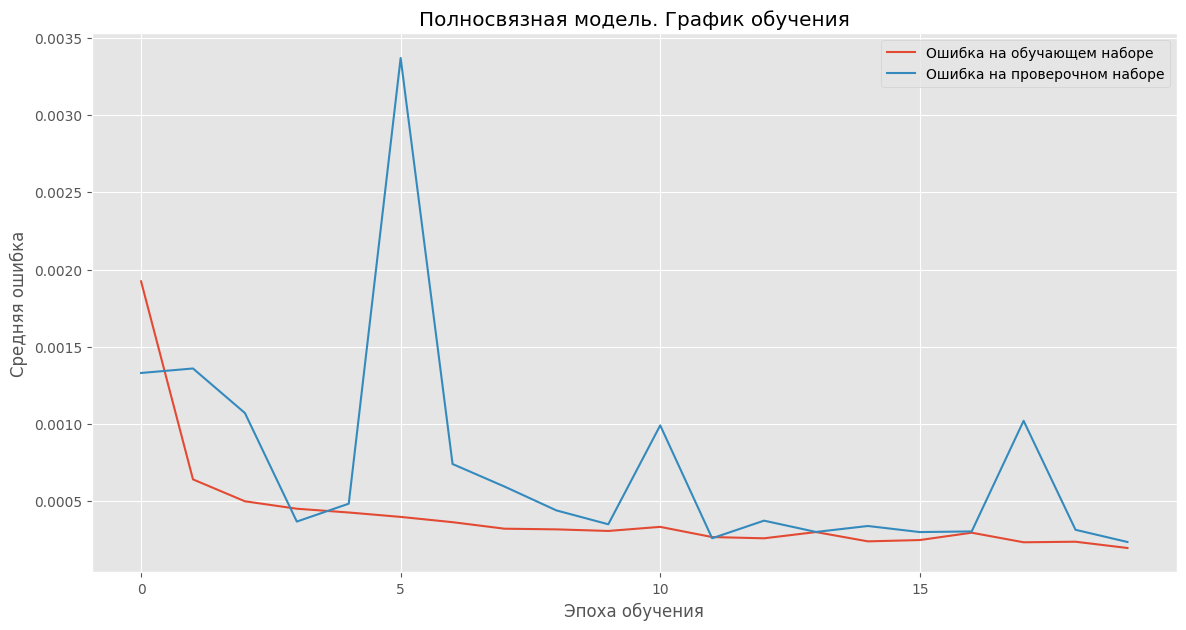

In [ ]:
# Графики
history_plot(model_dense.history, 'Полносвязная модель')

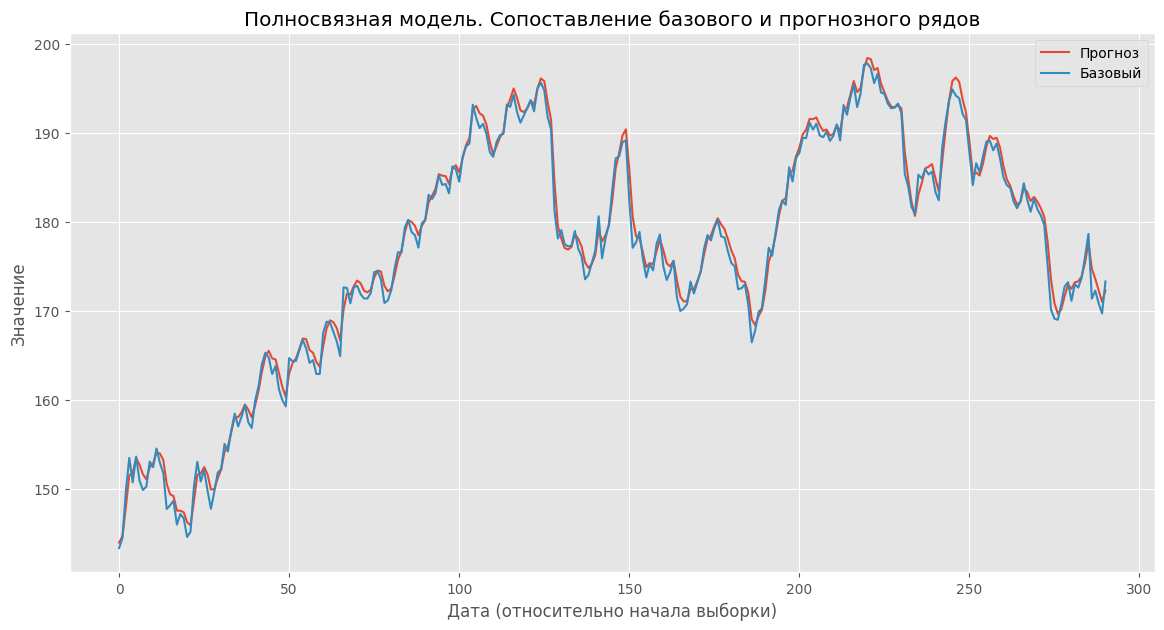

In [ ]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model_dense, x_test, y_test, scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
show_predict(y_pred, y_true, title=f'Полносвязная модель. Сопоставление базового и прогнозного рядов')

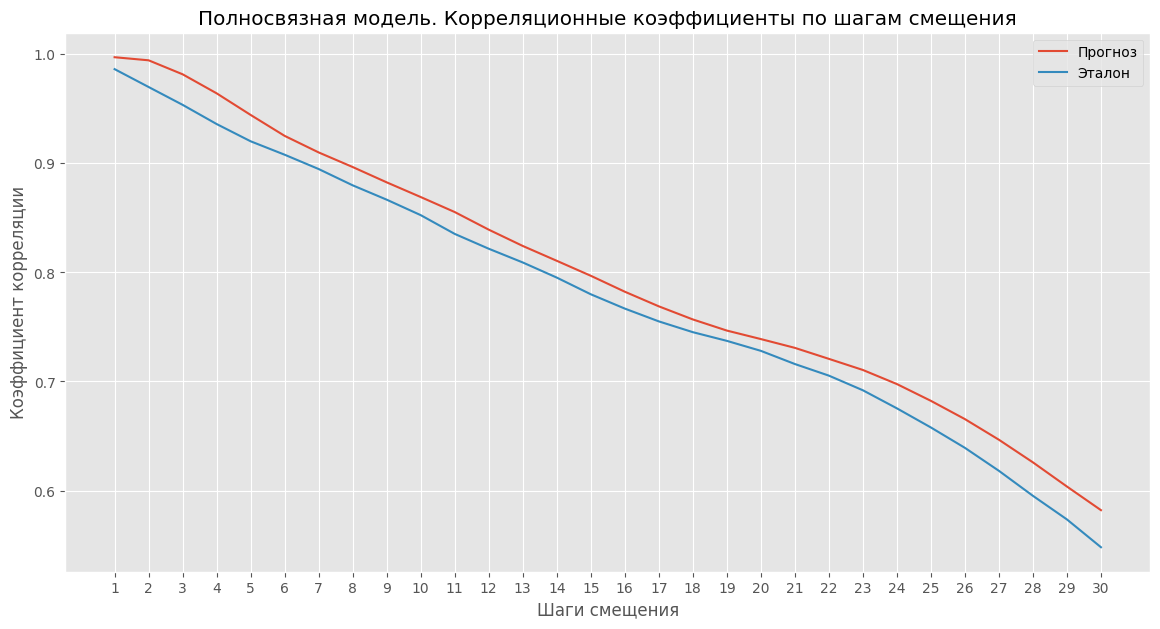

In [ ]:
# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, title=f'Полносвязная модель. Корреляционные коэффициенты по шагам смещения')